# Classifier visualisation

In [16]:
#
# imports
#
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from mpl_toolkits.mplot3d import Axes3D


import matplotlib.pyplot as plt 
import scipy.misc
import numpy as np
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation, merge, GlobalAveragePooling2D
from keras.layers.merge import Add, Multiply, Average, Maximum, Concatenate, Dot
from keras.models import Model
from keras.utils.layer_utils import print_summary
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import load_model

from keras import __version__ as kv
from scipy import __version__ as sv
from matplotlib import __version__ as mv
from numpy import __version__ as nv

print(kv)
print(sv)
print(mv)
print(nv)

2.0.8
0.19.1
2.1.0
1.12.1


In [17]:
#
# setup paths
#
model_dir = "/home/mike/git/temp_sar/resources/model_v1.0"
crops_dir = "/home/mike/git/temp_sar/resources/crops"   # chinese turbine crops
shapefile_dir = "/home/mike/git/temp_sar/resources/results_shapefile"
training_crops_dir = "/home/mike/git/temp_sar/resources/training/50x50/turbine" 


In [19]:
#
# load models
#
cnn_50x50 = load_model(os.path.join(model_dir, "fcn_50x50_v1.h5"))


In [20]:
#
# load results shapefile
#
results_df = gpd.read_file(os.path.join(shapefile_dir, "S1A_IW_GRDH_1SDV_20170924T100355_20170924T100420_018516_01F333_9052_withactual.shp"))


In [21]:
cnn_50x50.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 50, 50, 1)     0                                            
____________________________________________________________________________________________________
conv2d_19 (Conv2D)               (None, 50, 50, 32)    320         input_7[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D)  (None, 25, 25, 32)    0           conv2d_19[0][0]                  
____________________________________________________________________________________________________
conv2d_20 (Conv2D)               (None, 25, 25, 64)    18496       max_pooling2d_13[0][0]           
___________________________________________________________________________________________

In [26]:
#
# load Chinese 50x50 crops
#
list_of_50x50_crops = []
crop_save_dir_50x50 = os.path.join(crops_dir, '50x50')

list_of_distance_to_land_features = []

for idx, row in results_df.iterrows():
    list_of_distance_to_land_features.append(row['distance'])
    file_path = os.path.join(crop_save_dir_50x50, row['image_id'] + '_' + str(row['blob_id']) + '.png')

    image = scipy.misc.imread(file_path, 0)
    if image is not None:
        list_of_50x50_crops.append(image)
    else:
        print("Cannot open file: " + file_path)


array_of_50x50_crops = np.asarray(list_of_50x50_crops)
array_of_50x50_crops_disp = array_of_50x50_crops
array_of_distance_to_land_features = np.asarray(list_of_distance_to_land_features)
array_of_distance_to_land_features = np.expand_dims(array_of_distance_to_land_features, axis=1)
array_of_50x50_crops = np.expand_dims(array_of_50x50_crops, axis=3)

In [27]:
cnn_50x50.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
predictions = cnn_50x50.predict([array_of_50x50_crops, array_of_distance_to_land_features], batch_size=32, verbose=1)
preds = predictions[:, [0, 1, 2]].tolist()

160/166 [===========================>..] - ETA: 0s

In [28]:
preds

[[8.915075159166008e-05, 0.00306622963398695, 0.9968446493148804],
 [0.00041513898759149015, 0.0007747833151370287, 0.9988100528717041],
 [3.0065401006140746e-05, 0.00026294292183592916, 0.9997069239616394],
 [0.00013234507059678435, 0.0029635662212967873, 0.9969040751457214],
 [8.173619789886288e-06, 0.00016646005678921938, 0.9998254179954529],
 [0.35489562153816223, 0.0022976738400757313, 0.6428067088127136],
 [8.287807577289641e-05, 6.778699753340334e-05, 0.9998493194580078],
 [1.5776553482282907e-05, 7.024986643955344e-06, 0.9999772310256958],
 [4.172014087089337e-06, 3.4014926768577425e-06, 0.9999923706054688],
 [0.006646272260695696, 0.0012200303608551621, 0.992133617401123],
 [0.0013403723714873195, 0.00984631385654211, 0.9888133406639099],
 [5.693371349480003e-05, 0.00028771720826625824, 0.9996553659439087],
 [5.156775007009173e-09, 9.161092151543926e-08, 0.9999998807907104],
 [7.003142599160128e-08, 2.558069240876648e-07, 0.9999996423721313],
 [9.912448462046086e-08, 9.5988252

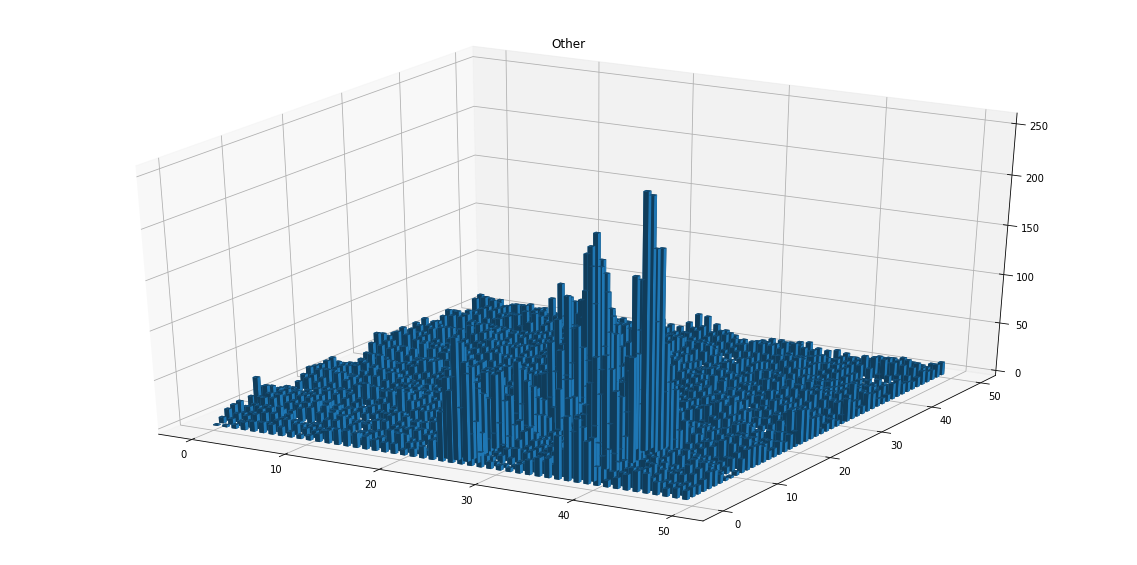

In [30]:
# Plot an other
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x_data, y_data = np.meshgrid(np.arange(array_of_50x50_crops_disp[0].shape[1]),
                           np.arange(array_of_50x50_crops_disp[0].shape[0]) )

x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = array_of_50x50_crops_disp[0].flatten()
ax.bar3d( x_data,
          y_data,
          np.zeros(len(z_data)),
          0.5, 0.5, z_data )
plt.title("Other")
plt.show()

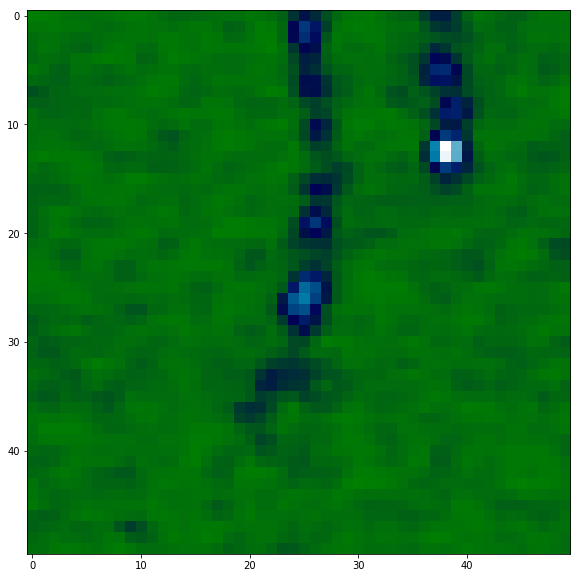

In [44]:
# TODO rotate to match 
plt.imshow(array_of_50x50_crops_disp[0], cmap='ocean')
plt.show()

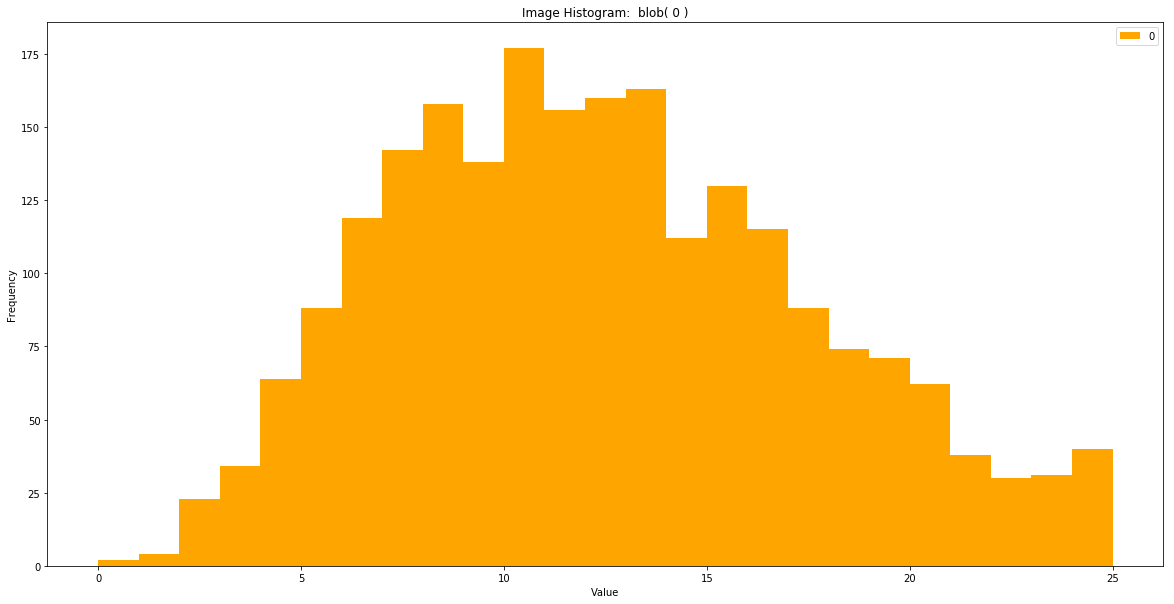

In [45]:
x = 0
plt.hist(array_of_50x50_crops_disp[0].flatten(), 25, range=(0, 25),histtype='bar', fill=True, color='orange', label=str(x))
plt.title("Image Histogram:  blob( " + str(x) + " )")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [114]:
# See https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

l = cnn_50x50.layers
conv_fn = K.function([l[0].input, K.learning_phase()], [l[-13].output]) #4
#conv_fn = K.function([l[0].input], [l[-4].output])

In [115]:
# # See https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

# l = model.layers
# conv_fn = K.function([l[0].input, K.learning_phase()], [l[-4].output])
# #conv_fn = K.function([l[0].input], [l[-4].output])

# def get_cm(inp, label):
#     conv = conv_fn([inp,0])[0][0,:,:,label]
#     return scipy.misc.imresize(conv, (50,50), interp='nearest')
# label_mappings = {"oil_and_gas_infrastructure": 0,
#                  "other": 1,
#                  "turbine": 2}

# #plot heat
# cm = get_cm(inp, 2)
# plt.imshow(cm, cmap="cool")


# #plot over image
# plt.figure(figsize=(10,12))
# plt.imshow(np.squeeze(valid_img), cmap='gray')
# plt.imshow(cm, cmap="cool", alpha=0.5)



In [116]:
def get_cm(inp, label):
    conv = conv_fn([inp,0])[0][0,:,:,label]
    return scipy.misc.imresize(conv, (50,50), interp='nearest')

In [117]:
x = 0
input1 = np.expand_dims(array_of_50x50_crops[x], 0)
input2 = np.expand_dims(array_of_distance_to_land_features[x], 0)
np.round(cnn_50x50.predict([input1, input2]))

#from training notebook ['oil', 'other', 'turbine'])


                           


array([[ 0.,  0.,  1.]], dtype=float32)

In [118]:
label_mappings = {"oil_and_gas_infrastructure": 0,
                 "other": 1,
                 "turbine": 2}

cm = get_cm(input1,2)

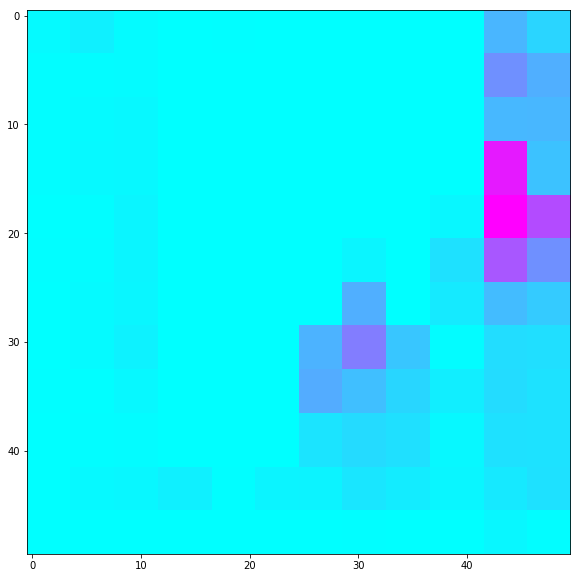

In [119]:
plt.imshow(cm, cmap="cool")
plt.show()

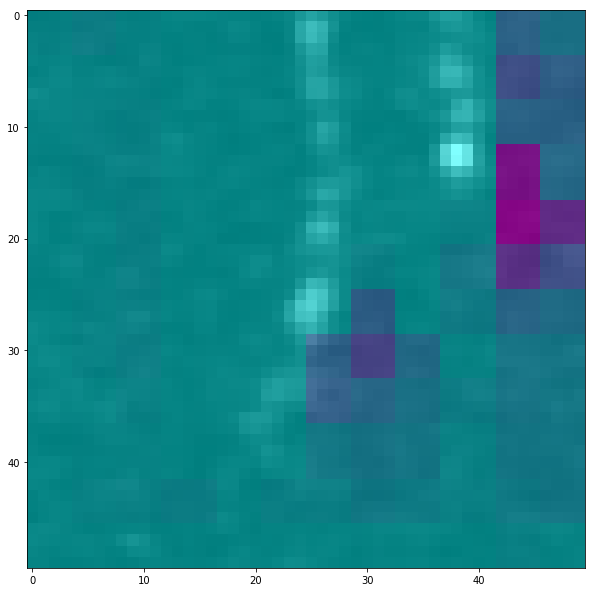

In [120]:
# #plot over image
plt.figure(figsize=(10,12))
plt.imshow(np.squeeze(array_of_50x50_crops_disp[0]), cmap='gray')
plt.imshow(cm, cmap="cool", alpha=0.5)
plt.show()

In [121]:
print(cm.shape)

(50, 50)
